In [180]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

## Group Assignment
### Team Number: 12
### Team Member Names: Jian Feng, Bogdan Basaraba, Ken Wu
### Team Strategy Chosen: (SAFE)


Our strategic choice aligns with a safe portfolio approach, characterized by specific criteria including low standard deviation, modest returns, and a Beta approximation close to zero. These metrics are fundamental in shaping our ideal portfolio, as they serve distinct purposes within our investment strategy.

The emphasis on a low standard deviation signifies our priority for minimizing risk within the portfolio. This criterion underscores our intent to maintain a level of predictability and stability in the portfolio's performance, which is crucial in our decision-making process.

Opting for a low percent return aligns with our strategy to have a portfolio with limited fluctuations in performance. By aiming for modest returns, we anticipate a more controlled movement in the portfolio's value, facilitating efficient adjustments to enhance overall portfolio performance.

Additionally, targeting a Beta close to zero indicates our preference for stocks exhibiting trends that closely mirror the behavior of the overall market. This choice reflects our intention to create a portfolio that maintains stability and is less susceptible to market volatilities.

In essence, these three chosen metrics collectively contribute to our objective of creating a controlled and stable portfolio, emphasizing risk management, controlled performance fluctuations, and alignment with market trends.

**Step1**
read in a .csv file called “Tickers.csv" containing tickers symbols and filter tickers that:
1.    do not reference a valid stock denominated in either USD or CAD.
2.   do not have an averge monthly volume of at least 150000 shares, from Jan 1st, 2023 to Oct 31th, 2023.
3.    do not have at least 18 trading days a month.
4.   duplicate tickers

In [181]:
# Date
start_date='2023-01-01'
end_date='2023-10-31'

# Read the CSV file
tickers_sample = pd.read_csv('Tickers_Example.csv', names=['Tickers'])
tickers_sample.head()
# Convert to list
temp = tickers_sample['Tickers'].to_numpy().tolist()

# Remove invalid or duplicated tickers
invalid_data = list(yf.shared._ERRORS.keys())
temp = [elt for elt in temp if elt not in invalid_data]
temp = list(set(temp))

# Create dataframe to store valid ticker information 
df_valid_tickers = pd.DataFrame(columns=['Ticker', 'Currency', 'ClosingPrice'])




In [182]:
# Filter ticker
for ticker in temp:
    try:
        stock = yf.Ticker(ticker)
        info = stock.fast_info
        
        # Criteria: Check for valid currency (USD or CAD)
        # Check if 'currency' information exists for the stock
        currency = info.get('currency')
        if not currency or currency not in ['USD', 'CAD']:
            continue  # Skip tickers with missing or invalid currency
        
        # Fetch historical data
        hist = stock.history(start=start_date, end=end_date)
        
        # Criteria: Check for average monthly volume
        monthly_volume = hist['Volume'].resample('M').mean()
        if any(monthly_volume < 150000):
            continue  # Skip tickers with average monthly volume < 150000
        
        # Criteria: Check for trading days
        trading_days = hist.resample('M').size()
        if any(trading_days < 18):
            continue  # Skip tickers with < 18 trading days a month
        
        # get the monthly closing price
        closing_price = hist['Close']
        new_row = pd.DataFrame({'Ticker': [ticker], 'Currency': [currency], 'ClosingPrice': [closing_price]})
        df_valid_tickers = pd.concat([df_valid_tickers, new_row], ignore_index=True)        
        

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

Now, let's proceed with calculating the absolute value of the difference from 1 and the mean of the monthly percent return, as well as the standard deviation of monthly returns for each ticker.

To calculate the monthly returns and standard deviation for each ticker:

In [183]:
# Initialize empty lists for monthly returns and standard deviations
monthly_returns = []
std_dev = []

# Calculate monthly returns and standard deviations for each ticker
for ticker in df_valid_tickers['Ticker']:
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date)
        monthly_close = hist['Close'].resample('M').ffill()
        
        # Calculate monthly returns
        monthly_return = abs(1 - monthly_close.pct_change()).mean()
        monthly_returns.append(monthly_return)
        
        # Calculate standard deviation of monthly returns
        monthly_std = monthly_close.pct_change().std()
        std_dev.append(monthly_std)
        
    except Exception as e:
        print(f"Error calculating metrics for {ticker}: {e}")

# Add calculated metrics to the dataframe
df_valid_tickers['MonthlyReturn'] = monthly_returns
df_valid_tickers['StdDev'] = std_dev

# Create series for order based on metrics
order_by_return = df_valid_tickers['MonthlyReturn'].rank(ascending=True)
order_by_std_dev = df_valid_tickers['StdDev'].rank(ascending=True)

# Combine the orders to get the combined order position
combined_order = order_by_return + order_by_std_dev

# Add combined order position to dataframe
df_valid_tickers['CombinedOrder'] = combined_order

# Sort tickers based on combined order position
sorted_tickers = df_valid_tickers.sort_values(by='CombinedOrder')['Ticker']



Once we have these metrics calculated and added to our df_valid_tickers dataframe, we proceed to create two series: one for the order based on the absolute value of the difference from 1 and the mean of the monthly percent return, and the other for the order based on the standard deviation of monthly returns.

In [184]:
# Create series for order based on metrics
order_by_return = df_valid_tickers['MonthlyReturn'].sort_values().rank(ascending=True)
order_by_std_dev = df_valid_tickers['StdDev'].sort_values().rank(ascending=True)

# Combine the orders to get the combined order position
combined_order = order_by_return + order_by_std_dev

# Add combined order position to dataframe
df_valid_tickers['CombinedOrder'] = combined_order

# Sort tickers based on combined order position
sorted_tickers = df_valid_tickers.sort_values(by='CombinedOrder')['Ticker']

To calculate the Beta for each ticker against the benchmark (^GSPC), we use the covariance and variance of the stock's returns with respect to the benchmark returns.
To calculate Beta for each ticker and then sort the tickers based on their Beta values:

In [185]:
# Define the benchmark ticker symbol
benchmark_symbol = '^GSPC'

# Function to fetch historical data for a ticker and the benchmark
def get_stock_data(ticker):
    try:
        # Fetch historical data for the given ticker
        stock = yf.Ticker(ticker)
        
        # Get the historical closing prices and calculate percentage changes
        stock_hist = stock.history(start=start_date, end=end_date)['Close'].pct_change().dropna()
        
        # Fetch historical data for the benchmark (^GSPC) and calculate percentage changes
        benchmark = yf.Ticker(benchmark_symbol)
        benchmark_hist = benchmark.history(start=start_date, end=end_date)['Close'].pct_change().dropna()
        
        return stock_hist, benchmark_hist
    except Exception as e:
        # Handle any errors that occur during data fetching
        print(f"Error fetching data for {ticker}: {e}")
        return None, None

# Initialize a 'Beta' column in df_valid_tickers with None values
df_valid_tickers['Beta'] = None 

# Calculate Beta for each ticker against the benchmark
for i, ticker in enumerate(df_valid_tickers['Ticker']):
    # Fetch stock and benchmark data
    stock_data, benchmark_data = get_stock_data(ticker)
    
    # Proceed if data is available for both stock and benchmark
    if stock_data is not None and benchmark_data is not None:
        # Calculate covariance and variance
        covariance = stock_data.cov(benchmark_data)
        variance = benchmark_data.var()
        
        # Calculate Beta and assign it to the 'Beta' column in the DataFrame
        beta = covariance / variance
        df_valid_tickers.loc[i, 'Beta'] = beta



In [186]:
# Calculate the 'CombinedOrder' by adding 'CombinedOrder' column values 
# with the absolute rank of 'Beta' values in ascending order
# The 'CombinedOrder' column will be updated by combining the current values 
# with the rank of absolute 'Beta' values, sorting them in ascending order
df_valid_tickers['CombinedOrder'] = df_valid_tickers['CombinedOrder'] + abs(df_valid_tickers['Beta']).rank(ascending=True)

**Step2**
We will conduct an analysis to calculate key performance measure, Beta. This measure will be computed to provide a further understanding of our portfolio's performance. Subsequently, we generate plot to visually represent it and conduct an analysis to ensure alignment with the previously stated objectives and criteria. This analysis aims to validate and demonstrate the consistency between our intended strategies and the actual outcomes observed within the portfolio.

To plot the data for the tickers with the highest, lowest, and closest-to-zero Beta values:

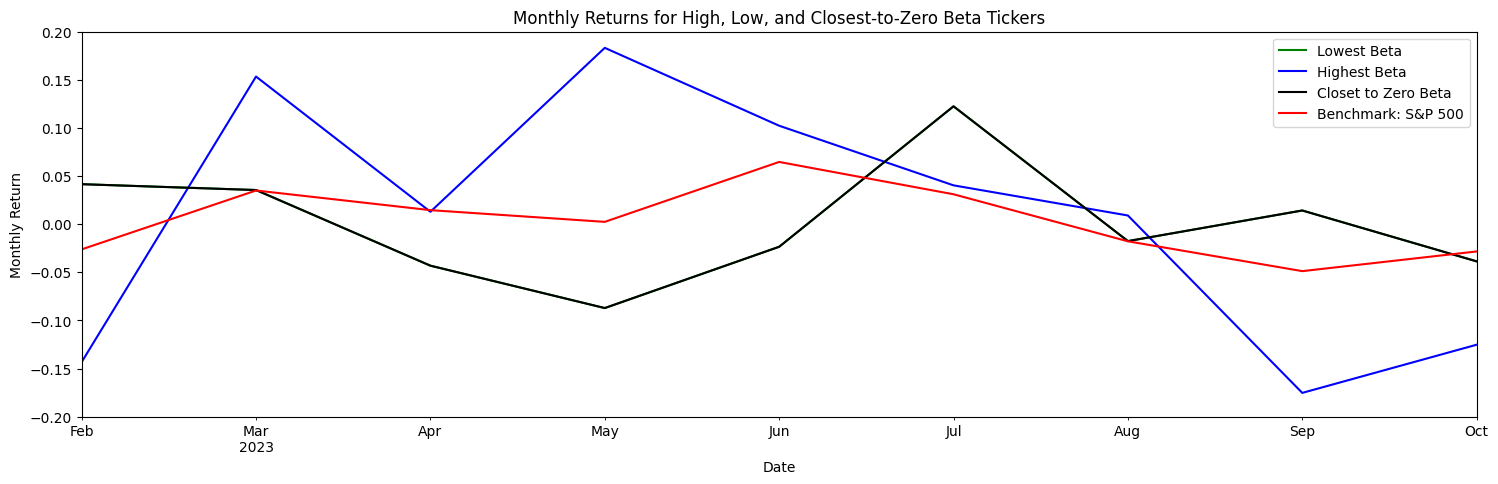

In [198]:

# Find tickers with highest, lowest, and closest-to-zero Beta
highest_beta_ticker = df_valid_tickers[df_valid_tickers['Beta'] == df_valid_tickers['Beta'].max()]['Ticker'].values[0]
lowest_beta_ticker = df_valid_tickers[df_valid_tickers['Beta'] == df_valid_tickers['Beta'].min()]['Ticker'].values[0]

# Find ticker closest to zero Beta (abs(Beta) closest to 0)
closest_to_zero_ticker = df_valid_tickers.iloc[(df_valid_tickers['Beta'] - 0).abs().argsort()[:1]]['Ticker'].values[0]

# Plotting monthly returns for identified tickers
plt.figure(figsize=(18, 5))
lowest_beta_ticker_l = yf.Ticker(lowest_beta_ticker)
lowest_beta_ticker_hist = lowest_beta_ticker_l.history(start=start_date, end=end_date)['Close'].resample('M').ffill().pct_change().dropna()
lowest_beta_ticker_hist.plot(label='Lowest Beta', color='green')

highest_beta_ticker_l = yf.Ticker(highest_beta_ticker)
highest_beta_ticker_hist = highest_beta_ticker_l.history(start=start_date, end=end_date)['Close'].resample('M').ffill().pct_change().dropna()
highest_beta_ticker_hist.plot(label='Highest Beta', color='blue')

close_0_beta_ticker_l = yf.Ticker(closest_to_zero_ticker)
close_0_beta_ticker_hist = close_0_beta_ticker_l.history(start=start_date, end=end_date)['Close'].resample('M').ffill().pct_change().dropna()
close_0_beta_ticker_hist.plot(label='Closet to Zero Beta', color='black')

benchmark = yf.Ticker(benchmark_symbol)
benchmark_hist = benchmark.history(start=start_date, end=end_date)['Close'].resample('M').ffill().pct_change().dropna()
benchmark_hist.plot(label='Benchmark: S&P 500', color='red')
# Add labels, legend, title, etc. as needed
plt.ylim(-.2, .2) 
plt.legend()
plt.title('Monthly Returns for High, Low, and Closest-to-Zero Beta Tickers')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.show()


Notice: the green line is actually the black line They represent the same ticker so the green line is shadowed by black line.

The strategic selection of stocks exhibiting a Beta close to zero within our portfolio stems from a meticulous consideration of risk mitigation and consistency in performance. The plot depicting the monthly returns of three distinct stocks—each characterized by varying Beta values—provides valuable insights into the inherent volatility and alignment with market trends. Notice that the ticker with the lowest Beta is actually the ticker with the Beta closet to 0.

Upon analysis, the stock with the highest Beta value manifests considerable fluctuations in its monthly returns. This substantial deviation from the market benchmark implies heightened volatility and a greater degree of risk associated with its performance.

Contrarily, the stock demonstrating a Beta close to zero exhibits a more consistent and stable trend in its monthly returns. This alignment with the market suggests a diminished susceptibility to extreme fluctuations, thereby contributing to a more predictable and controlled performance. The minimal deviation from the market benchmark positions such stocks as viable components within a safe portfolio strategy, emphasizing the pursuit of stability and risk containment.

In essence, the preference for stocks demonstrating a Beta close to zero resonates with our objective to construct a safe portfolio, prioritizing consistency, stability, and an alignment with market trends to mitigate the inherent risks associated with investment fluctuations.

**Step3**
form dataframe called “Portfolio_Final” with columns of Ticker, Price, Currency, Shares, Value, Weight.

In [188]:
# Create an empty DataFrame with specified columns
Portfolio_Final = pd.DataFrame({
    'Ticker': [],
    'Price': [],
    'Currency': [],
    'Shares': [],
    'Value': [],
    'Weight': []
})
initial_investment = 750000 #CAD

Notice: For each stock purchased, there's an additional cost of 4.95 CDN per stock. Also, there's a restriction in place: each stock selected must collectively represent between 0.227% and 20% of the portfolio's value when considered in proportion to their respective values.

The following prepares the portfolio by distributing the initial investment among selected stocks based on their order and handles currency conversion for USD-denominated stocks. Besides, we decided to choose the maximum possible number of stocks to form our portfolio, whether it is limited by the maximum eligible stocks or the limit on how many stocks we can buy. The reason behind this is similar to the concept of diversification, such that by purchasing as many stocks as possible, any shock, or change to one stock will affect the overall portfolio value marginally less significantly than if we had fewer stocks in the portfolio.

In [189]:
# Function to convert stock prices from USD to CAD
def convert_prices_to_cad(close_price_usd):
    # Fetch the USD to CAD exchange rate using Yahoo Finance
    usd_to_cad_rate = yf.Ticker('CADUSD=X').history(start=start_date, end=end_date)["Close"].tz_localize(None)  
    if close_price_usd is not None and usd_to_cad_rate is not None:
        close_price_cad = close_price_usd * usd_to_cad_rate
    return close_price_cad.iloc[-1]

# Determine the maximum number of stocks allowed
num_stock = min(22, len(df_valid_tickers.index))  # Maximum number of stocks allowed

# Order the tickers based on their combined order
df_ordered = df_valid_tickers.sort_values(by='CombinedOrder', ascending=True)

# Calculate the weight for each stock in the portfolio
weight = (1 / num_stock) 

# Initialize investment, flat fee, and calculate initial ticker value
investment = initial_investment
flat_fee = 4.95  # CAD
ticker_value = (initial_investment - num_stock * flat_fee) * weight
total_weight = 1 
# Iterate through each ticker in the ordered dataframe up to the maximum number of stocks
for ticker in df_ordered['Ticker'][:num_stock]:
    if total_weight <=0:
        break

    ticker_data = yf.Ticker(ticker)
    ticker_info = ticker_data.fast_info
    ticker_currency = ticker_info.get('currency')

    # Check if the stock is denominated in USD
    if ticker_currency == 'USD':
        # Call the convert_prices_to_cad function to convert the price to CAD
        close_price_cad = convert_prices_to_cad(ticker_data.history(start=start_date, end=end_date)["Close"].iloc[-1])
    else:
        close_price_cad = ticker_data.history(start=start_date, end=end_date)["Close"].iloc[-1]
    
    # Calculate the number of shares for the current stock
    ticker_shares = ticker_value / close_price_cad

    # Create a new DataFrame for the current stock and append it to the Portfolio_Final DataFrame
    df_new_stock = pd.DataFrame({
        'Ticker': [ticker],
        'Price': [close_price_cad],
        'Currency': ['CAD'],
        'Shares': [ticker_shares],
        'Value': [ticker_value],
        'Weight': [weight]
    })
    total_weight -= weight
    Portfolio_Final = pd.concat([Portfolio_Final, df_new_stock], ignore_index=True)

This DataFrame is printed to the screen as the second to last output to the screen.  The final output to the screen will be a declaration to be detailed below. 

In [190]:
print ("The total value of the portfolio is: " + str(Portfolio_Final['Value'].sum()))
print ("The total weight of the portfolio is: " + str(Portfolio_Final['Weight'].sum()))

The total value of the portfolio is: 749891.1000000001
The total weight of the portfolio is: 0.9999999999999998


Creating "Stocks_Final" to export into a .csv file


Finally to create a DataFrame called “Portfolio_Final” where the index starts at 1 and ends at the number of stocks of our portfolio and outputs it to csv file named "Stocks_Group_12.csv".

In [191]:

Stocks_Final = pd.DataFrame() # outputs the final dataframe with the recommended stocks
Stocks_Final['Ticker'] = Portfolio_Final['Ticker'] # creates a columns with the tickers for each stock in the portfolio
Stocks_Final['Shares'] = Portfolio_Final['Shares'] # creates a column with the shares for each stock in the portfolio
# Reset the index starting from 1
Portfolio_Final.reset_index(drop=True, inplace=True)
Portfolio_Final.index = Portfolio_Final.index + 1
Stocks_Final.to_csv('Stocks_Group_12.csv') # exports final portfolio to a csv file

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Jian Feng, Bogdan Basaraba, Ken Wu